In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from scipy.stats import norm
import plotly.graph_objects as go
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, StepLR, OneCycleLR
from pathlib import Path
import matplotlib.animation as animation
from sklearn.datasets import *



from rich import print
import imageio


from utils.Models import MLP
from utils.Datasets import BBdataset
from utils.utils import *
seed = 233
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 0
print(f"Using device: {device}")


experiment_name = "gaussian2S_change_epsilon_norm"  # 你可以根据需要动态设置这个变量
# log_dir = Path('experiments') / experiment_name / 'test' / time.strftime("%Y-%m-%d/%H_%M_%S/")
log_dir = Path('experiments') / experiment_name
log_dir.mkdir(parents=True, exist_ok=True)
os.environ["CUDA_VISIBLE_DEVICES"]="1"


Using device: 0

In [2]:
# 生成初始和目标密度样本
def gen_data(m=4, num_samples=1000):
    mus = [(m, m), (m, -m), (-m, m), (-m, -m)]
    source_dist = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], num_samples)
    target_dist = make_s_curve(n_samples=num_samples, noise=0.01)[0][:, ::2] * 2
    return source_dist, target_dist

# 生成二维Brownian bridge
def gen_bridge_2d(x, y, ts, T, num_samples):
    sigma = 1
    bridge = torch.zeros((ts.shape[0], num_samples, 2))
    drift = torch.zeros((ts.shape[0], num_samples, 2))
    bridge[0] = x
    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]
        dydt = (y - bridge[i]) / (T - ts[i])
        drift[i, :] = dydt
        diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples, 2)
        bridge[i+1] = bridge[i] + dydt * dt
        bridge[i+1, :] += diffusion
    return bridge, drift

# 主函数
def gen_2d_data(m=4, num_samples=1000, epsilon=0.001, T=1):
    if not isinstance(num_samples, int):
        num_samples = int(num_samples)
    source_dist, target_dist = gen_data(m, num_samples)
    ts = torch.arange(0, T+epsilon, epsilon)
    source_dist = torch.Tensor(source_dist)
    target_dist = torch.Tensor(target_dist)
    bridge, drift = gen_bridge_2d(source_dist, target_dist, ts, T=T, num_samples=num_samples)
    return ts, bridge, drift, source_dist, target_dist

ts, bridge, drift, source_sample, target_sample = gen_2d_data(num_samples=1000)

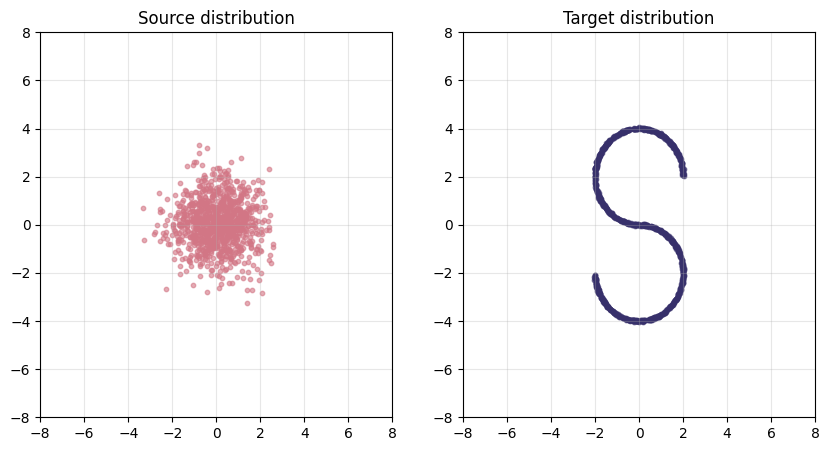

In [3]:
def plot_source_and_target(sour, targ, left_title="Source distribution", right_title="Target distribution", save_path=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].scatter(*sour.T, c='#D27685', s=10, alpha=0.6)
    axs[1].scatter(*targ.T, c='#37306B', s=10, alpha=0.6)
    axs[0].set_title(left_title)
    axs[1].set_title(right_title)
    axs[0].grid(True, alpha=0.3)
    axs[1].grid(True, alpha=0.3)
    axs[0].set_xlim(-8, 8)
    axs[0].set_ylim(-8, 8)
    axs[1].set_xlim(-8, 8)
    axs[1].set_ylim(-8, 8)
    fig.show()
    if save_path is not None:
        fig.savefig(save_path)

plot_source_and_target(source_sample, target_sample)

In [4]:
def draw_gaussian2d(bridge, colors=True):
    def get_color(point):
        x, y = point
        if x > 0 and y > 0:
            return 0
        elif x > 0 and y < 0:
            return 1
        elif x < 0 and y > 0:
            return 2
        else:
            return 3

    # 生成数据
    color_list = ['#37306B', '#66347F', '#9E4784', '#D27685']  # 对应于目标均值的颜色

    # 创建3D图形
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 为每个样本绘制bridge
    for i in range(bridge.shape[1]):
        x = bridge[:, i, 0].numpy()  # X坐标
        y = bridge[:, i, 1].numpy()  # Y坐标
        z = ts.numpy()               # 时间作为Z坐标
        c = color_list[get_color((x[-1], y[-1]))] if colors else '#D27685'
        ax.plot(x, y, z, color=c, label=f'Sample {i+1}', alpha=0.3)

    # 添加标签和图例
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Time')

    fig.show()

In [5]:
def draw_gaussian2d_gif(bridge):
    def get_color(point):
        x, y = point
        if x > 0 and y > 0:
            return 0
        elif x > 0 and y < 0:
            return 1
        elif x < 0 and y > 0:
            return 2
        else:
            return 3
    colors = ['b', 'g', 'r', 'c']  # 对应于目标均值的颜色
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    # 定义更新函数
    def update(frame):
        ax.clear()
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)
        for i in range(bridge.shape[1]):
            x = bridge[:frame + 1, i, 0].numpy()  # 注意：frame + 1
            y = bridge[:frame + 1, i, 1].numpy()  # 注意：frame + 1
            if x.size > 0 and y.size > 0:  # 确保x和y不为空
                color_index = get_color((x[-1], y[-1]))
                ax.plot(x, y, color=colors[color_index], alpha=0.5)
                ax.scatter(x[-1], y[-1], color=colors[color_index], alpha=1, s=10)
    # 创建动画
    ani = animation.FuncAnimation(fig, update, frames=len(ts), interval=100)
    # 保存为GIF需要花费6分钟左右
    ani.save(log_dir / 'brownian_bridge.gif', writer='imagemagick')

In [6]:
num_samples = 10000
ts, bridge, drift, source_sample, target_sample = gen_2d_data(num_samples=num_samples)
# print_debug(ts, bridge, drift, source_sample, target_sample)
start = torch.cat(torch.split(source_sample.repeat(len(ts)-1, 1, 1), 1, dim=1), dim=0)
times = ts[:len(ts)-1].repeat(num_samples, 1).reshape(-1, 1, 1)
positions = torch.cat(torch.split(bridge[:-1, :], 1, dim=1), dim=0)

scores = torch.cat(torch.split(drift[:-1, :], 1, dim=1), dim=0)
# print_debug(start, times, positions, scores)
raw_data = torch.concat([start, times, positions, scores], dim=-1)
raw_data.shape

torch.Size([10000000, 1, 7])

In [7]:
# 计算均值和标准差
mean = torch.mean(raw_data, dim=0)
std = torch.std(raw_data, dim=0)

# 使用Z-Score标准化进行归一化
normalized_data = (raw_data - mean) / std

In [8]:
epochs = 50
batch_size = 200000
lr = 1e-4

# 组合成data
train_ds = BBdataset(normalized_data)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=20)

model = MLP(input_dim=5, output_dim=2, hidden_layers=2, hidden_dim=256).to(device)
loss_fn = nn.MSELoss()
loss_list = []
print('='*10+'model'+'='*10)
print("batch_szie:{}, channel:{}, length:{}".format(*next(train_dl.__iter__()).shape)) # batch_szie, channel, length
print(model)

==========model==========

batch_szie:200000, channel:1, length:7

MLP(
  (fcin): Linear(in_features=5, out_features=256, bias=True)
  (fcs): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fcout): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)

In [18]:
def train(model, train_dl, optimizer, scheduler, loss_fn):
    losses = 0
    for training_data in train_dl:
        training_data = training_data.to(device)
        # x: (batch_size, channel, length-2), y: (batch_size, channel, 2)
        x, y = training_data[:, 0, :-2], training_data[:, 0, -2:] # 不同模型要改
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
        losses += loss.item() / len(train_dl)
        
    return losses
from torch.optim.lr_scheduler import OneCycleLR

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
epochs = 200
# scheduler = OneCycleLR(optimizer, max_lr=1e-4, total_steps=epochs*len(train_dl))
scheduler = None

epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
model.train()
model.to(device)
for e in epoch_iterator:
    now_loss = train(model ,train_dl, optimizer, scheduler, loss_fn)
    loss_list.append(now_loss)
    cur_lr = optimizer.param_groups[-1]['lr']
    epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, now_loss))
epoch_iterator.close()

Training (lr: X)  (loss= X):   0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
torch.save(model.state_dict(), log_dir / 'model.pth')

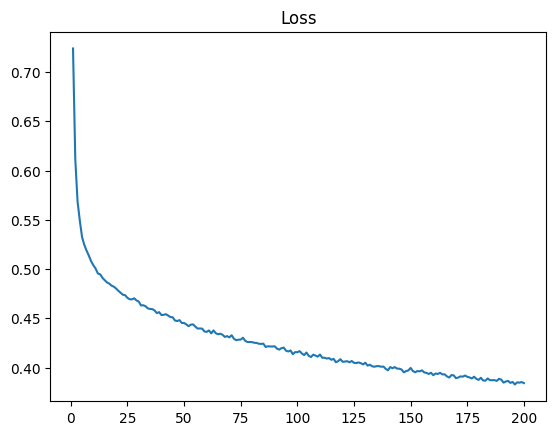

In [11]:
plt.plot(range(1, len(loss_list)+1), loss_list)
plt.title('Loss')
plt.show()

In [12]:
test_num_samples = 4000
test_ts, test_bridge, test_drift, test_source_sample, test_target_sample = gen_2d_data(num_samples=test_num_samples)
# print_debug(test_ts, test_bridge, test_drift, test_source_sample, test_target_sample)
pred_bridge = torch.zeros_like(test_bridge)
pred_bridge[0, :] = test_source_sample
model.eval()
model.to(device)
sigma=1
with torch.no_grad():
    for i in range(len(test_ts) - 1):
        dt = (test_ts[i+1] - test_ts[i])
        test_source_sample_reshaped = test_source_sample.reshape(-1, 1, test_source_sample.shape[-1])
        test_ts_reshaped = test_ts[i].reshape(-1, 1, 1).repeat(test_num_samples, 1, 1)
        pred_bridge_reshaped = pred_bridge[i].reshape(-1, 1, pred_bridge.shape[-1])
        x = torch.concat([test_source_sample_reshaped, test_ts_reshaped, pred_bridge_reshaped], axis=-1)
        x = (x - mean[:, :-2]) / std[:, :-2]
        dydt = model(x[:,0,:].to(device)).cpu()
        # print_debug(dydt)
        dydt = dydt * std[0,-2:] + mean[0,-2:]
        diffusion = sigma * torch.sqrt(dt) * torch.randn(test_num_samples, 2)
        pred_bridge[i+1, :] = pred_bridge[i, :] + dydt * dt + diffusion
        
        
        
        # dt = ts[i+1] - ts[i]
        # dydt = (y - bridge[i]) / (T - ts[i])
        # drift[i, :] = dydt
        # diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples, 2)
        # bridge[i+1] = bridge[i] + dydt * dt + diffusion

In [13]:
# draw_gaussian2d(bridge, False)

In [14]:
# draw_gaussian2d(pred_bridge, False)

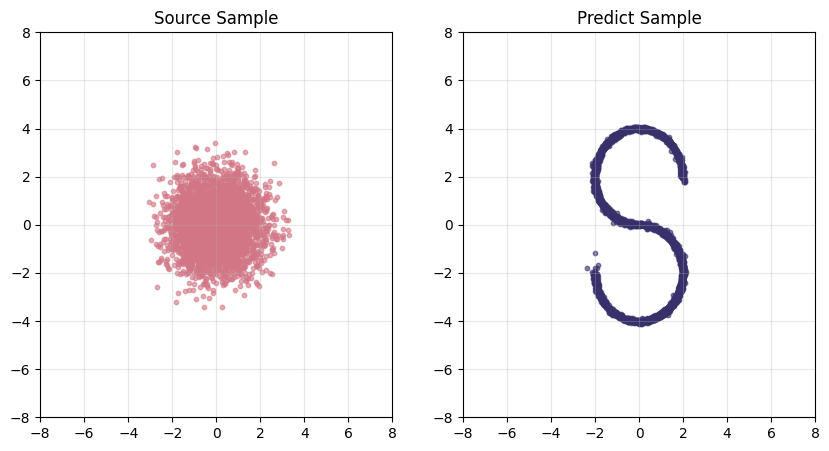

In [15]:
plot_source_and_target(pred_bridge[0, :, :], pred_bridge[-1, :, :], left_title="Source Sample", right_title="Predict Sample", save_path=log_dir / 'pred_bridge.jpg')

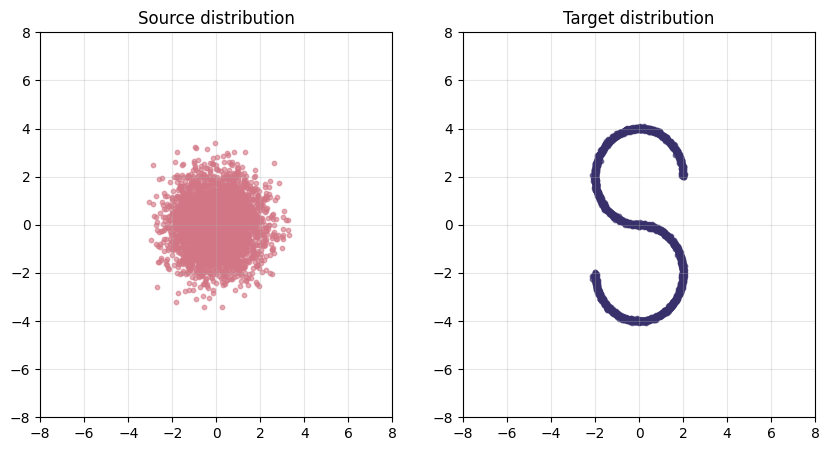

In [16]:
plot_source_and_target(test_bridge[0, :, :], test_bridge[-1, :, :], save_path=log_dir / 'gt_test_bridge.jpg')

In [17]:
save_gif_frame(pred_bridge, log_dir)

Output()